In [28]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random

import sys
sys.path.append('/home/sol/Escritorio/paper_reservoir/')


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction

In [2]:
def reservoir_performance_example(data_source, adj_matrix, input_weight=None,
                          spectral_radius_scale=0.9, with_bias=True):

    if hasattr(adj_matrix, "todense"):
        adj_matrix = adj_matrix.todense()
    adj_matrix = np.asarray(adj_matrix)

    # Generate dataset
    [x, y] = data_source.func(sample_len=1000)
    #print(len(x))

    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)

    if spectral_radius_scale:
        spectral_radius = get_spectral_radius(weights)
        if spectral_radius == 0:
            raise RuntimeError("Nilpotent adjacency matrix matrix")
        weights *= spectral_radius_scale / spectral_radius

    in_scaling = 0.05
    in_weight = input_weight * in_scaling

    res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                i_sig.ravel())
                    for i_sig in x]
    rregr = RidgeRegression(use_bias=with_bias)
    [rregr.train(x_train, y_train)
     for x_train, y_train in zip(res_dynamics[:-1], y[:-1])]
    pred = rregr(res_dynamics[-1])
    nrmse_res = nrmse(pred, y[-1])

    if np.isnan(nrmse_res) or np.isinf(nrmse_res):
        raise RuntimeError("The NRMSE value obtained is not finite.")

    return pred, y[-1], x[-1]

In [29]:
def reservoir_performance(data_source, adj_matrix, input_weight=None,
                          spectral_radius_scale=0.9, with_bias=True):

    if hasattr(adj_matrix, "todense"):
        adj_matrix = adj_matrix.todense()
    adj_matrix = np.asarray(adj_matrix)

    # Generate dataset
    [x, y] = data_source.func(sample_len=1000)
    #print(len(x))

    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)

    if spectral_radius_scale:
        spectral_radius = get_spectral_radius(weights)
        if spectral_radius == 0:
            raise RuntimeError("Nilpotent adjacency matrix matrix")
        weights *= spectral_radius_scale / spectral_radius

    in_scaling = 0.05
    in_weight = input_weight * in_scaling

    res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                i_sig.ravel())
                    for i_sig in x]
    rregr = RidgeRegression(use_bias=with_bias)
    [rregr.train(x_train, y_train)
     for x_train, y_train in zip(res_dynamics[:-1], y[:-1])]
    pred = rregr(res_dynamics[-1])
    nrmse_res = nrmse(pred, y[-1])

    if np.isnan(nrmse_res) or np.isinf(nrmse_res):
        raise RuntimeError("The NRMSE value obtained is not finite.")

    return nrmse_res


class _data_source():
    def __init__(self, name, func):
        self.name = name
        self.func = func


data_sources = [_data_source("10th order NARMA", narma10),
                _data_source("30th order NARMA", narma30)]

cp_file_layout = "multy_{task}NARMA_{system}_{num_trials}trials.cp"

Performance is evaluated with the Normalized Root Mean Squared Error (NRSME) between expected and reconstructed outputs. The NRMSE value shown for each biological network topology corresponds to the median of 10 000 trials (with edge weights and data series randomization).

In [30]:
GRN_systems = [grn for index, grn in enumerate(grn_networks.grn_names)
                   if grn.lower()=='ecocyc']
graph = grn_networks.load_network(GRN_systems[0])
graph = nt.prune_graph(graph, verbose=1)


Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [31]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
SR_scale = 0.9
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5)
inputs_arr[num_inputs:] = 0
rand_inputs = True
num_trials = 1000
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)

In [32]:
noNilpotent_trials = 0
results = []
while len(results) < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    if SR_scale and get_spectral_radius(adj_matrix) == 0:
        #print("Spectral radius --> 0")
        noNilpotent_trials += 1
        if noNilpotent_trials > 10000:
            print("NO-NILPOTENT MATRIX NOT FOUND!")
            raise ValueError
        continue
    results.append(reservoir_performance(data_sources[0], adj_matrix,
                                        input_weight=inputs_arr,
                                        spectral_radius_scale=SR_scale))
    print(len(results))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [33]:
np.mean(results)

0.3472207521100955

In [7]:
np.mean(results)

0.3472207521100955

In [6]:

if rand_inputs:
    np.random.shuffle(inputs_arr)

pred, output_target, input = reservoir_performance_example(data_sources[0], adj_matrix,
                                    input_weight=inputs_arr,
                                    spectral_radius_scale=SR_scale)


(500.0, 700.0)

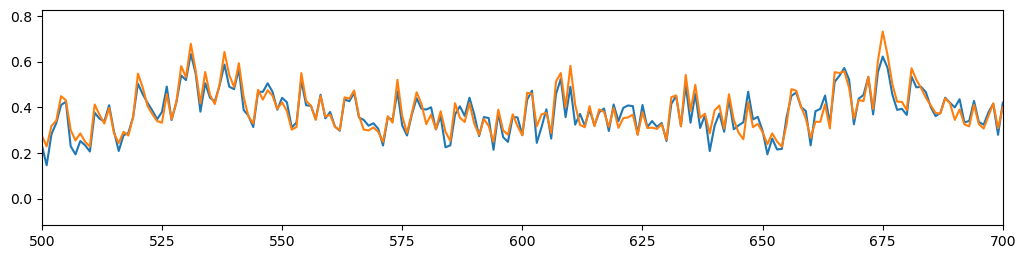

In [7]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=[12.4, 2.8])
plt.plot(pred)
plt.plot(output_target)
plt.xlim((500,700))
#plt.plot(input)

(500.0, 700.0)

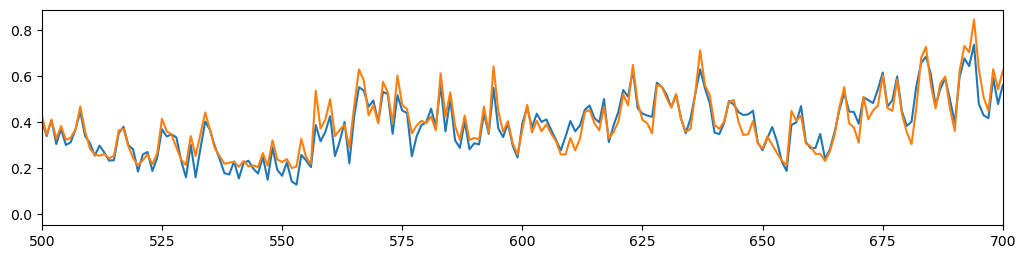

In [16]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=[12.4, 2.8])
plt.plot(pred)
plt.plot(output_target)
plt.xlim((500,700))
#plt.plot(input)